# Online ads

In this problem set we analyse the relationship between online ads and purchase behavior. In particular, we want to classify which online users are likely to purchase a certain product after being exposed to an online ad.  

## Data preparation

In [1]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/kirenz/datasets/master/purchase.csv")
df

,Unnamed: 0,User ID,Gender,Age,EstimatedSalary,Purchased
0,1,15624510,Male,19,19000,0
1,2,15810944,Male,35,20000,0
2,3,15668575,Female,26,43000,0
3,4,15603246,Female,27,57000,0
4,5,15804002,Male,19,76000,0
...,...,...,...,...,...,...
395,396,15691863,Female,46,41000,1
396,397,15706071,Male,51,23000,1
397,398,15654296,Female,50,20000,1
398,399,15755018,Male,36,33000,0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       400 non-null    int64 
 1   User ID          400 non-null    int64 
 2   Gender           400 non-null    object
 3   Age              400 non-null    int64 
 4   EstimatedSalary  400 non-null    int64 
 5   Purchased        400 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 18.9+ KB


In [3]:
# make dummy variable
df['male'] = pd.get_dummies(df['Gender'], drop_first = True)
# drop irrelevant columns
df.drop(columns= ['Unnamed: 0', 'User ID', 'Gender'], inplace = True)

In [4]:
# inspect outcome variable
df['Purchased'].value_counts()

0    257
1    143
Name: Purchased, dtype: int64

In [5]:
# prepara data for scikit learn 
X = df.drop(columns=['Purchased'])
y = df.Purchased

In [6]:
# make data split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 1)

In [7]:
# create new training dataset for data exploration
train_dataset = pd.DataFrame(X_train).copy()
train_dataset['Purchased'] = pd.DataFrame(y_train)

train_dataset

,Age,EstimatedSalary,male,Purchased
39,27,31000,0,0
167,35,71000,0,0
383,49,28000,1,1
221,35,91000,1,1
351,37,75000,1,0
...,...,...,...,...
255,52,90000,0,1
72,20,23000,0,0
396,51,23000,1,1
235,46,79000,1,1


## Exploratory data analysis (EDA)

In [8]:
train_dataset.groupby(by=['Purchased']).describe().T

Purchased                          0              1
Age             count     185.000000      95.000000
                mean       32.621622      45.821053
                std         7.957603       8.756735
                min        18.000000      27.000000
                25%        27.000000      39.000000
                50%        33.000000      47.000000
                75%        38.000000      52.500000
                max        59.000000      60.000000
EstimatedSalary count     185.000000      95.000000
                mean    58556.756757   89505.263158
                std     22429.073482   43284.038059
                min     15000.000000   20000.000000
                25%     43000.000000   43500.000000
                50%     60000.000000   97000.000000
                75%     75000.000000  130000.000000
                max    134000.000000  150000.000000
male            count     185.000000      95.000000
                mean        0.518919       0.452632
                std         0.500998       0.500392
                min         0.000000       0.000000
                25%         0.000000       0.000000
                50%         1.000000       0.000000
                75%         1.000000       1.000000
                max         1.000000       1.000000

Purchasers are (on average) _______ and earn a __________ estimated salary than non-purchasers. 

Visualization of differences:

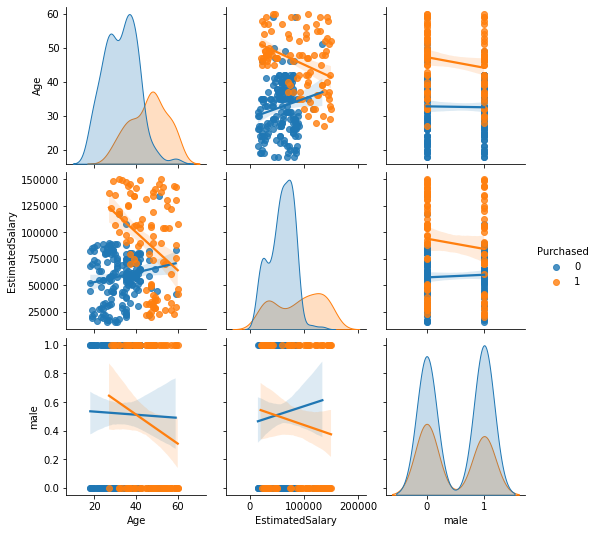

In [9]:
import seaborn as sns

sns.pairplot(hue='Purchased', kind="reg", diag_kind="kde", data=train_dataset);

Inspect (linear) relationships between variables with correlation (pearson's correlation coefficient)

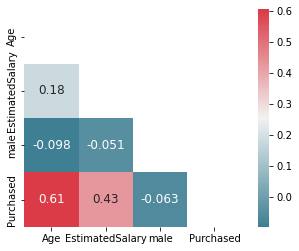

In [10]:
import numpy as np

# Calculate correlation using the default method ( "pearson")
corr = train_dataset.corr()
# optimize aesthetics: generate mask for removing duplicate / unnecessary info
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
# Generate a custom diverging colormap as indicator for correlations:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Plot
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, square=True, annot_kws={"size": 12});

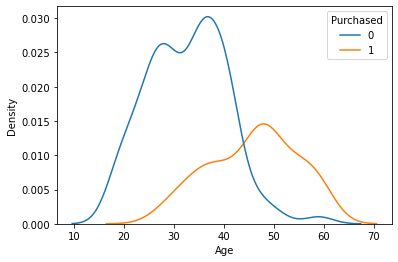

In [11]:
sns.kdeplot(hue="Purchased", x='Age', data=train_dataset);

Purchasers seem to be _________ than non-purchaser.

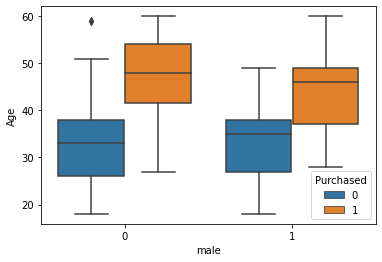

In [12]:
sns.boxplot(x="male", y="Age", hue="Purchased", data=train_dataset);

There are __________ differences regarding gender.

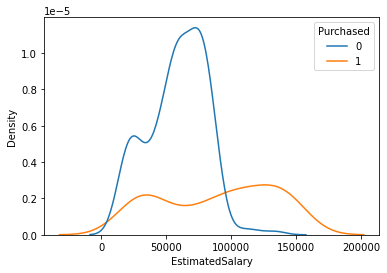

In [13]:
sns.kdeplot(hue="Purchased", x='EstimatedSalary', data=train_dataset); 

Purchaser earn a ______________ estimated salary.

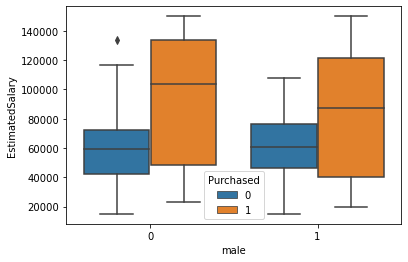

In [14]:
sns.boxplot(x="male", y="EstimatedSalary", hue="Purchased", data=train_dataset);

Insight: there are ___________ differences between males and females (regarding purchase behavior, age and estimated salary)

## Model

Next, we will fit a logistic regression model with a [L2 regularization (ridge regression)](https://developers.google.com/machine-learning/crash-course/regularization-for-simplicity/l2-regularization). In particular, we use an estimator that has built-in cross-validation capabilities to automatically select the best hyper-parameter for our L2 regularization (see the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV)).

We only use our most promising predictor variables `Age` and `EstimatedSalary` for our model.

In [15]:
# only use meaningful predictors
features_model = ['Age', 'EstimatedSalary']

X_train = X_train[features_model] 
X_test = X_test[features_model]

In [16]:
import sklearn.linear_model as skl_lm

# model
clf = skl_lm.LogisticRegressionCV(penalty='l2')

# fit model to data
clf.fit(X_train, y_train)

# prediction
y_pred = clf.predict(X_test)

## Classification metrics

In [17]:
# Return the mean accuracy on the given test data and labels:
clf.score(X_test, y_test)

0.7833333333333333

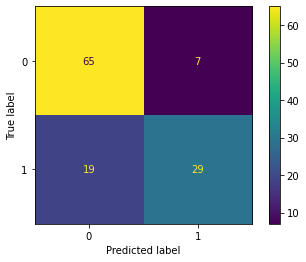

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test);

In [19]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.77      0.90      0.83        72
         Yes       0.81      0.60      0.69        48

    accuracy                           0.78       120
   macro avg       0.79      0.75      0.76       120
weighted avg       0.79      0.78      0.78       120



``macro``: Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

``weighted``: Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters 'macro' to account for label imbalance.

Note that recall is also sometimes called sensitivity or true positive rate.

* High scores for both *precision* and *recall* show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

* The importance of precision vs recall depends on the use case at hand (and the costs associated with missclassification). 

* A system with *high recall* but *low precision* returns many results, but most of its predicted labels are incorrect when compared to the training labels. 

* A system with *high precision* but *low recall* is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels. 
  
* An ideal system with high precision and high recall will return many results, with most results labeled correctly. 

The unweighted recall of our model is _____  

The unweighted precision of our model is _____  

### ROC Curve

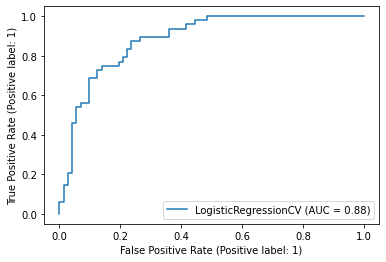

In [22]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(clf, X_test, y_test) ;

### AUC Score


In [23]:
from sklearn.metrics import roc_auc_score

y_score = clf.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_score)

0.8842592592592593

## Thresholds

Logistic regression returns a probability. You can use the returned probability "as is" (for example, the probability that the user will buy the product is 0.8) or convert the returned probability to a binary value (for example, this user will buy the product, therefore we label him as "Yes").

A logistic regression model that returns 0.9 for a particular customer is predicting that it is very likely that the customer will buy the product. In order to map a logistic regression value to a binary category (e.g., "Yes" or "No"), you must define a **classification threshold** (also called the decision threshold). A value above that threshold indicates "Yes", the customer will buy the product; a value below indicates "No", the customer will not buy the product. 

Notice that the optimal classification threshold is problem-dependent and therefore a value that you must tune (see [Google developers](https://developers.google.com/machine-learning/crash-course/classification/thresholding)).

We use three different thresholds. Which threshold would you recommend?

In [24]:
pred_proba = clf.predict_proba(X_test)

### Threshold  0.4

              precision    recall  f1-score   support

           0       0.84      0.79      0.81        72
           1       0.71      0.77      0.74        48

    accuracy                           0.78       120
   macro avg       0.77      0.78      0.78       120
weighted avg       0.79      0.78      0.78       120



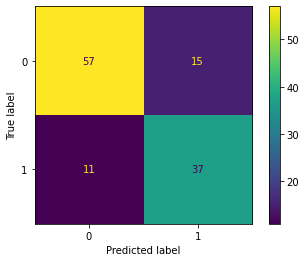

In [26]:
df_04 = pd.DataFrame({'y_pred': pred_proba[:,1] > .4})

ConfusionMatrixDisplay.from_predictions(y_test, df_04['y_pred']);

print(classification_report(y_test, df_04['y_pred']))

### Threshold 0.5

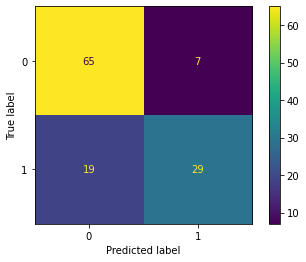

              precision    recall  f1-score   support

           0       0.77      0.90      0.83        72
           1       0.81      0.60      0.69        48

    accuracy                           0.78       120
   macro avg       0.79      0.75      0.76       120
weighted avg       0.79      0.78      0.78       120



In [47]:
df_05 = pd.DataFrame({'y_pred': pred_proba[:,1] > .5})

ConfusionMatrixDisplay.from_predictions(y_test, df_05['y_pred']);

print(classification_report(y_test, df_05['y_pred']))

### Threshold 0.7

              precision    recall  f1-score   support

           0       0.66      0.96      0.78        72
           1       0.80      0.25      0.38        48

    accuracy                           0.68       120
   macro avg       0.73      0.60      0.58       120
weighted avg       0.71      0.68      0.62       120



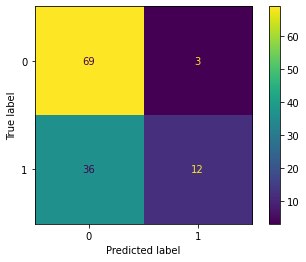

In [27]:
df_07 = pd.DataFrame({'y_pred': pred_proba[:,1] > .7})

ConfusionMatrixDisplay.from_predictions(y_test, df_07['y_pred']);

print(classification_report(y_test, df_07['y_pred']))